# Evaluating Forecasts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

plt.rcParams['figure.figsize'] = (14,6)

### Overview: 
Step 1 - 5: See encounter "Analyzing time series"  
Step 6 - 9: See encounter "Linear Autoregression"  
Step 10: Evaluating the model  
Step 11: Testing  
Step 12: Predicting into the future -> Exercise

# Step 1 - Load the Data

In [2]:
flights = pd.read_csv('flights.csv', index_col=0, parse_dates=True)
flights.head()

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80


### Plot the data

In [3]:
def plot_flights(df, title='Monthly Passenger Numbers in 1000 over Time', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset.
    
    Parameters
    ----------
    df : pd.DataFrame, the data to plot.
    title : str, the title of the plot.
    ylim : bool, whether to fix the minimum value of y; defalut is True.
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

# Step 2 -  Train-Test-Split

In [4]:
# same as yesterday:
flights_train = flights[:'Dec 1959'].copy()
flights_test = flights['Jan 1960':].copy()

# Step 3 - Extract the Timestep and the Seasonal Dummies

In [5]:
# Create a timestep variable (trend)
flights_train['timestep'] = list(range(len(flights_train)))
flights_train.head()

,passengers,timestep
date,,
1949-01-01,64,0
1949-02-01,75,1
1949-03-01,98,2
1949-04-01,93,3
1949-05-01,80,4


In [6]:
# Create the seasonal dummies for seasonality
seasonal_dummies = pd.get_dummies(flights_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(flights_train.index)

flights_train = flights_train.join(seasonal_dummies)

In [7]:
flights_train.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0


# Step 4 Model the Trend_Seasonal model

In [8]:
# Define X and y
X = flights_train.drop(columns=['passengers'])
y = flights_train['passengers']

In [9]:
# Create and fit the model
m_ts = LinearRegression()
m_ts.fit(X, y)

LinearRegression()

In [10]:
# Create a new column with the predictions of the trend_seasonal model
flights_train['trend_seasonal'] = m_ts.predict(X)
flights_train.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0,59.594697
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061


# Plot the original data and preliminary model

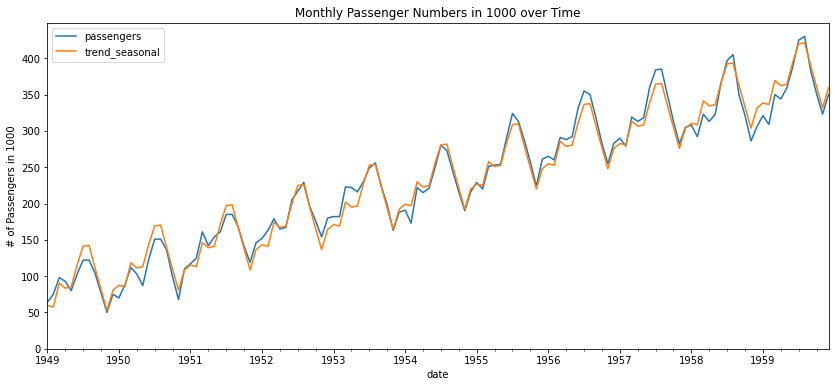

In [11]:
plot_flights(flights_train[['passengers', 'trend_seasonal']])

# Step 5 - Extract the remainder

In [12]:
# We want to extract the part of the model that the trend_seasonal is not able to explain
flights_train['remainder'] = flights_train['passengers'] - flights_train['trend_seasonal']

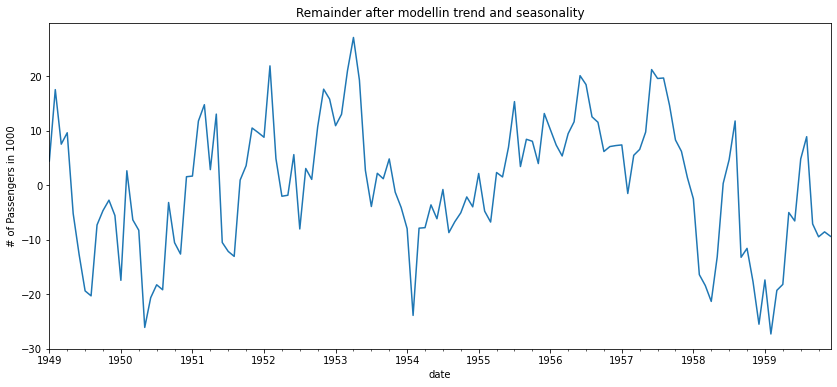

In [13]:
plot_flights(flights_train['remainder'], title='Remainder after modellin trend and seasonality', ylim=False)

# Step 6 - Inspect the remainder to decide how many lags to include


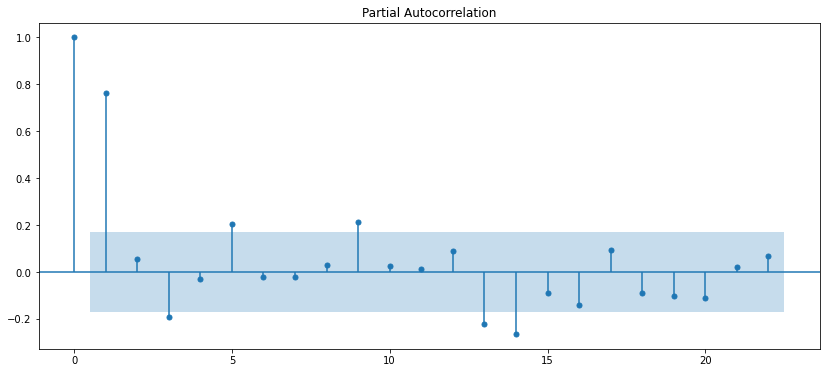

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(flights_train['remainder']);

# Step 7 - Add the lags of the remainder to the training data

In [15]:
flights_train['lag1'] = flights_train['remainder'].shift(1)
flights_train.dropna(inplace=True)
flights_train.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061


# Step 8 - Run the full model

In [16]:
# Assign X
X_full = flights_train.drop(columns=['passengers', 'trend_seasonal', 'remainder'])
y_full = flights_train['passengers']

In [17]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061


In [18]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [19]:
# Create a new predictions column
flights_train['predictions_full_model'] = m_full.predict(X_full)

# Step 9 - Plot the prediction vs passengers for the training data

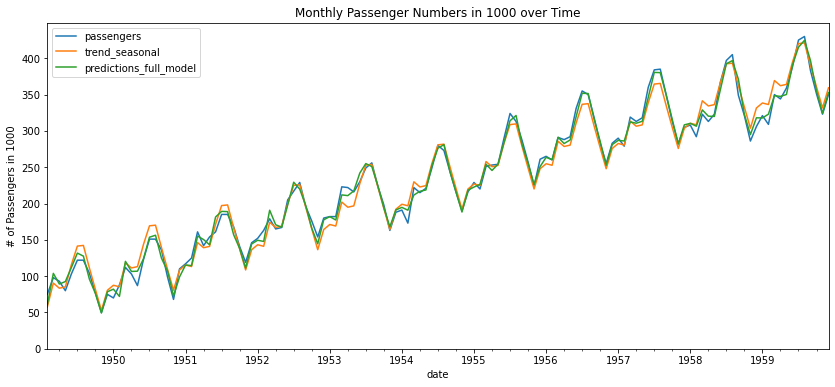

In [20]:
plot_flights(flights_train[['passengers', 'trend_seasonal', 'predictions_full_model']])

In [ ]:
# Until here: nothing new. 

# Is this model good?

# Step 10 - Evaluate our model

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.

Cross-validation so far:

- Dividing training data into subsets (folds)
- in each iteration singled out one fold as validation set
- trained on the remaining training data and evaluated the fit on the validation set.

Cross-validation for time series:

- Dividing training data into subsets (folds)
- in the first iteration, use the first fold to evaluate the second fold
- in the second iteration, use the first and the second fold to evaluate the third fold
- ...

In [ ]:
# Create a TimeSeriesSplit object


In [ ]:
# See how the folds work: 
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

In [ ]:
# Create the time series split


In [ ]:
# Do the cross validation


# Evaluation Metrics Overview

### 1. Mean Absolute Error (MAE)

$\frac{1}{n} \sum |y_t - \hat{y}_t|$

#### Advantages:

- Error is in the unit of interest, interpretable
- Does not overly value outliers

#### Disadvantages:

- Not comparable across models with different units
- not the cheapest computationally

### 2. Mean-Squared-Error (MSE)

$\frac{1}{n} \sum (y_t - \hat{y_t}) ^2$

#### Advantages:
- Is widely implemented
- strong penalty on outliers

#### Disadvantages:
- Strong penalty on outliers
- Unit hardly interpretable
- Not comparable across models with different units

### 3. Root-Mean-Squared-Error (RMSE)

$\sqrt{\frac{1}{n} \sum (y_t - \hat{y_t}) ^2}$

#### Advantages:
- Errors in the unit of interest, but not as interpretable as MAE
- penalizes large errors

#### Disadvantages:
- Can only be compared between models whos errors are measured in the same unit

### 4. Root Mean Squared Log Error (RMSLE)

$\sqrt{\frac{1}{n} \sum (log(y_t + 1) - log(\hat{y_t} + 1) ^2}$

#### Advantages:
- Captures relative error
- Penalizes underestimation stronger than overestimation
- good when: target has exponential growth

### 5. Mean Absolute Percent Error (MAPE)

$\frac{1}{n} \sum |\frac{y_t - \hat{y}_t}{y_t}| * 100$

#### Advantages:
- Comparable over different models as it is scale independent
- intuitive interpretation

#### Disadvantages:
- Is not defined for 0 values
- unstable for very small values
- asymmetric: favours underestimations

### 6. $R^2$

$1 - \frac{\sum{(y_i - \hat{y_i})^2}}{\sum{(y_i - \bar{y})^2}}$

Goodness-of-Fit-Measure, proportion of variance explained by the model. 
Best possible score: 1. 

### 7. AIC (Akaike Information Criterion)
$2k − 2ln(\hat{L})$

Also Goodness-of-Fit-Measure. Relative information value, lower is better. Penalizes models with many parameters.  
Useful to compare models trained on the same dataset.

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y_full, add_constant(X_full)).fit()
regr.aic

In [ ]:
regr.summary()

# 11) - Test your model

In [ ]:
# Last timestep of the training data


In [ ]:
# Create a timestep for the model


In [ ]:
# Create seasonal dummies
seasonal_dummies = pd.get_dummies(flights_test.index.month, 
                                  prefix='month', 
                                 drop_first=True).set_index(flights_test.index)

flights_test = flights_test.join(seasonal_dummies)
flights_test.head()

In [ ]:
# Assign X_test
X_test = flights_test.drop(columns=['passengers'])

In [ ]:
# Predict trend and seasonality


In [ ]:
# Calculate the remainder for the test set


In [ ]:
# Create the lagged variable


In [ ]:
# Assign X_full
X_full_t = flights_test.drop(columns=['passengers', 'trend_seasonal', 'remainder'])

In [ ]:
# Create the predictions


In [ ]:
# Create the complete dataset and plot it
flights_full = flights_train[['passengers', 'trend_seasonal', 'predictions_full_model']].append(flights_test[['passengers', 'trend_seasonal', 'predictions_full_model']])

In [ ]:
plot_flights(flights_full)

# Exercise
1. Go trough Step 12, run and explore the code and try to see what is going on.   
Most of this is very similar to step 11, but you will be able to predict further into the future than your test-dataset! 

2. Then, apply cross-validation to the project-data. 

# Step 12 - Predict the future

So far we have just predicted data that we already had (train and test). We have not actually made any predictions for the future.

In [ ]:
# Combine train and test data -> whole dataset with all features we created. 
flights_combined = flights_train.append(flights_test)
flights_combined.tail()

In [ ]:
# Assign X and y 
X_combined = flights_combined.drop(columns=['passengers', 'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = flights_combined['passengers']

In [ ]:
X_combined.tail(12) # NaN for 1960-01-01

In [ ]:
X_combined.loc['1960-01-01', 'lag1'] = flights_train.loc['1959-12-01', 'remainder']

In [ ]:
# Re-train the model on the whole dataset
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

In [ ]:
# What is the first date in the future? --> 1961-01-01
timestep = flights_combined['timestep'].max() + 1
months = [0] * 11  # because it is January, which is the first dummy-feature (which we dropped)
lag = flights_combined.loc['1960-12-01', 'remainder']

In [ ]:
# create a new sample
X_future = []

In [ ]:
X_future.append(timestep)
X_future

In [ ]:
X_future.extend(months)
X_future

In [ ]:
X_future.append(lag)
X_future

In [ ]:
X_future = pd.DataFrame([X_future], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1'])
X_future.rename(index={0:pd.to_datetime("1961-01-01 00:00:00")},inplace=True)
X_future

In [ ]:
# Prediction for 1961-01-01
m_combined.predict(X_future)

In [ ]:
X_future['predictions_full_model'] = m_combined.predict(X_future)

In [ ]:
# How does this look like for 1961-02-01?
timestep = flights_combined['timestep'].max() + 2
months = [1] + [0]*10
lag = 0 
# This is too far in the future to calculate the lag; our best guess will be a lag of 0. 
# So we are predicting only trend and seasonality here. 

In [ ]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1'])
X_future_2.rename(index={0:pd.to_datetime("1961-02-01 00:00:00")},inplace=True)
X_future_2

In [ ]:
# Prediction for 1961-02-01
m_combined.predict(X_future_2)

In [ ]:
X_future_2['predictions_full_model'] = m_combined.predict(X_future_2)

In [ ]:
# create one df for plotting
cols = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'passengers', 'trend_seasonal', 'predictions_full_model']
flights_f = flights_test[cols].append(X_future)
flights_future = flights_f.append(X_future_2)

In [ ]:
plot_flights(flights_future[['passengers', 'trend_seasonal', 'predictions_full_model']], ylim=False)